<h1>Stock analysis prototyping<h1>

<h3>Module Import</h3>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
from matplotlib.dates import MO, FR
import requests

<h3>Input</h3>

In [2]:
SYMBOL = 'BABA'
START_DATE = '2022-08'
SEC = { 'apikey': 'TBA3334ORY8D6QNZ' }
ALPHA_URL = 'https://www.alphavantage.co/query?'
HEADERS = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
YAHOO_STATIC_URL = 'https://query2.finance.yahoo.com/v10/finance/quoteSummary/'

<h3>Functions</h3>

In [16]:
def get_index_search_date (dates, searchdate):

    l = []
    for item in dates:
            if item.find(searchdate) == 0:
                l.append(item)
    l.sort()

    return dates.index(l[0]) + 1


def rollingavg(L, window):

    avg_list = []
    result = []

    for idx in range(len(L)):
        avg_list.append(L[idx])

        if idx + 1 < window:
            result.append(None)
        else:
            avg = sum(avg_list) / window
            result.append(avg)
            avg_list = avg_list[1:]

    #print(result)
    return result[window:]

<h3>Alphavantage API fetch</h3>

In [3]:
import requests

# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = f"https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol={SYMBOL}&apikey={SEC['apikey']}"
r = requests.get(url)
data = r.json()

print(data)

{'symbol': 'BABA', 'annualReports': [{'fiscalDateEnding': '2023-03-31', 'reportedCurrency': 'CNY', 'grossProfit': '318992000000', 'totalRevenue': '868687000000', 'costOfRevenue': '549695000000', 'costofGoodsAndServicesSold': '549695000000', 'operatingIncome': '100351000000', 'sellingGeneralAndAdministrative': '42183000000', 'researchAndDevelopment': '56744000000', 'operatingExpenses': '215927000000', 'investmentIncomeNet': 'None', 'netInterestIncome': '-16989000000', 'interestIncome': '5918000000', 'interestExpense': '16989000000', 'nonInterestIncome': 'None', 'otherNonOperatingIncome': 'None', 'depreciation': 'None', 'depreciationAndAmortization': '22041000000', 'incomeBeforeTax': '89185000000', 'incomeTaxExpense': '15549000000', 'interestAndDebtExpense': 'None', 'netIncomeFromContinuingOperations': '65573000000', 'comprehensiveIncomeNetOfTax': 'None', 'ebit': '100351000000', 'ebitda': '122392000000', 'netIncome': '72783000000'}, {'fiscalDateEnding': '2022-03-31', 'reportedCurrency': 

In [17]:
api_input = {
    'symbol' : SYMBOL,
    'function' : 'TIME_SERIES_DAILY',
    'outputsize': 'full',
    'datatype' : 'json',
}

api_url =   (
        ALPHA_URL + 'function=' + api_input['function'] +
        '&symbol=' + api_input['symbol'] +
        '&outputsize=' + api_input['outputsize'] +
        '&datatype=' +  api_input['datatype'] +
        '&apikey=' + SEC['apikey']
)

api_fetch = requests.get(api_url)
dataset = api_fetch.json() # transform to dict

<h3>Yahoo finance API fetch</h3>

In [18]:
api_settings = {
    'symbol' : SYMBOL,
    'datasets' : [
        #'assetProfile'
        #,'summaryProfile'
        #,'summaryDetail'
        #,'esgScores'
        #,'price'
        'incomeStatementHistory'
        ,'incomeStatementHistoryQuarterly'
        ,'balanceSheetHistory'
        ,'balanceSheetHistoryQuarterly'
        ,'cashflowStatementHistory'
        ,'cashflowStatementHistoryQuarterly'
        #,'defaultKeyStatistics'
        #,'financialData'
        #,'calendarEvents'
        #,'secFilings'
        #,'recommendationTrend'
        #,'upgradeDowngradeHistory'
        #,'institutionOwnership'
        #,'fundOwnership'
        #,'majorDirectHolders'
        #,'majorHoldersBreakdown'
        #,'insiderTransactions'
        #,'insiderHolders'
        #,'netSharePurchaseActivity'
        #,'earnings'
        #,'earningsHistory'
        #,'earningsTrend'
        #,'industryTrend'
        #,'indexTrend'
        #,'sectorTrend'
        ]
        }

api_url = YAHOO_STATIC_URL + api_input['symbol'] + '?modules=' + ''.join([x + '%2C' for x in api_settings['datasets']])[:-3]
api_fetch = requests.get(api_url, headers=HEADERS)
yahoo_dataset = api_fetch.json() # transform to dict

In [19]:
def parse_yahoo_financials (dataset, module):

    def parse_dict (D, search, format):

        L = []

        for idx in range(len(D)):
            if search in D[idx]:
                L.append(D[idx].get(search).get(format))

        return L


    outer_keys = list(dataset['quoteSummary']['result'][0][module].keys())
    outer_keys.remove('maxAge')
    nested_data = dataset['quoteSummary']['result'][0][module][outer_keys[0]]
    keys = list(nested_data[0].keys())
    keys.remove('maxAge')

    value_lists = []

    for key in keys:
        if key == 'endDate':
            value_lists.append(parse_dict(nested_data, key, 'fmt'))
        else:
            value_lists.append(parse_dict(nested_data, key, 'raw'))

    d = {key: val for (key, val) in zip(keys,value_lists)}

    return d


income_statement_yearly = parse_yahoo_financials (yahoo_dataset, 'incomeStatementHistory')
income_statement_quarterly = parse_yahoo_financials (yahoo_dataset, 'incomeStatementHistoryQuarterly')

cash_flow_yearly = parse_yahoo_financials (yahoo_dataset, 'cashflowStatementHistory')
cash_flow_quarterly = parse_yahoo_financials (yahoo_dataset, 'cashflowStatementHistoryQuarterly')

balance_sheet_yearly = parse_yahoo_financials (yahoo_dataset, 'balanceSheetHistory')
balance_sheet_quarterly = parse_yahoo_financials (yahoo_dataset, 'balanceSheetHistoryQuarterly')

#print(income_statement_yearly, cash_flow_yearly, balance_sheet_yearly, sep='\n\n')


<h3>Income statement</h3>

In [20]:
# transform income statement to table with date as columns and statements as index
income_statement = pd.pivot_table(pd.DataFrame(income_statement_yearly), columns=['endDate'], dropna=True)

#print(income_statement)


new_sorted_idx = []

for item in list(income_statement_yearly.keys()):
    if item in list(income_statement.index):
        new_sorted_idx.append(item)

#income_statement = income_statement.reindex(new_sorted_idx)

# missing
#operating_expenses = income_statement.loc['researchDevelopment'] + income_statement.loc['sellingGeneralAdministrative']

gross_margin = income_statement.loc['grossProfit'] / income_statement.loc['totalRevenue'] * 100
#ops_expenses_margin = ( income_statement.loc['researchDevelopment'] + income_statement.loc['sellingGeneralAdministrative'] ) / income_statement.loc['totalRevenue'] * 100

if 'researchDevelopment' in income_statement:
    rd_margin = income_statement.loc['researchDevelopment'] / income_statement.loc['totalRevenue'] * 100
    income_statement.loc['r&dMargin%'] = rd_margin

admin_margin = income_statement.loc['sellingGeneralAdministrative'] / income_statement.loc['totalRevenue'] * 100
ops_margin = income_statement.loc['operatingIncome'] / income_statement.loc['totalRevenue'] * 100
net_margin =  income_statement.loc['netIncome'] / income_statement.loc['totalRevenue'] * 100

# append to income_statement


#income_statement.loc['operatingExpenses'] = operating_expenses

income_statement.loc['grossMargin%'] = gross_margin

income_statement.loc['adminMargin%'] = admin_margin
income_statement.loc['operatingMargin%'] = ops_margin
income_statement.loc['netMargin%'] = net_margin

income_statement.drop(['totalOperatingExpenses', 'netIncomeFromContinuingOps', 'netIncomeApplicableToCommonShares', 'ebit'])

income_statement


/tmp/ipykernel_10518/891293108.py:2: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  income_statement = pd.pivot_table(pd.DataFrame(income_statement_yearly), columns=['endDate'], dropna=True)


endDate,2019-03-31,2020-03-31,2021-03-31,2022-03-31
costOfRevenue,2.040860e+11,2.797130e+11,4.195170e+11,5.387050e+11
ebit,6.160600e+10,9.553400e+10,1.095940e+11,9.649700e+10
grossProfit,1.727580e+11,2.299980e+11,2.977720e+11,3.143570e+11
incomeBeforeTax,9.678700e+10,1.609120e+11,1.725620e+11,7.389400e+10
incomeTaxExpense,1.655300e+10,2.056200e+10,2.927800e+10,2.681500e+10
interestExpense,-5.190000e+09,-5.180000e+09,-4.476000e+09,-4.909000e+09
minorityInterest,1.163260e+11,1.151470e+11,1.374910e+11,1.240590e+11
netIncome,8.788600e+10,1.494330e+11,1.505780e+11,6.224900e+10
netIncomeApplicableToCommonShares,8.760000e+10,1.492630e+11,1.503080e+11,6.195900e+10
netIncomeFromContinuingOps,8.023400e+10,1.403500e+11,1.432840e+11,4.707900e+10


<h3>Cash flow</h3>
<p>
A cash flow statement is a financial statement that provides aggregate data regarding all cash inflows a company receives from its ongoing operations and external investment sources. It also includes all cash outflows that pay for business activities and investments during a given period. It follows the cash made by the business in three main ways—through operations, investment, and financing. The sum of these three segments is called net cash flow.
</p>

In [21]:
# transform income statement to table with date as columns and statements as index
cash_flow = pd.pivot_table(pd.DataFrame(cash_flow_yearly), columns=['endDate'], dropna=True)

new_sorted_idx = [
    'netIncome',
    'totalCashFromOperatingActivities',
    'capitalExpenditures',
    'depreciation',
    'totalCashflowsFromInvestingActivities',
    'otherCashflowsFromInvestingActivities',
    'totalCashFromFinancingActivities',
    'dividendsPaid',
    'otherCashflowsFromFinancingActivities',
    'issuanceOfStock',
    'repurchaseOfStock'
    ]

cash_flow = cash_flow.reindex(new_sorted_idx)

free_cash_flow = cash_flow.loc['totalCashFromOperatingActivities'] + cash_flow.loc['capitalExpenditures']
cash_flow.loc['freeCashFlow'] = free_cash_flow


capexMargin = cash_flow.loc['capitalExpenditures'] / income_statement.loc['totalRevenue'] * 100
cash_flow.loc['capexMargin'] = capexMargin


total_stock_repurchases = cash_flow.loc['issuanceOfStock'] + cash_flow.loc['repurchaseOfStock']
cash_flow.loc['totalStockRepurchases'] = total_stock_repurchases


shareholder_payout_from_fcf = ( total_stock_repurchases + abs(cash_flow.loc['dividendsPaid']) ) / abs(free_cash_flow) * 100
cash_flow.loc['shareholderPayoutRatioFCF'] = shareholder_payout_from_fcf


cash_flow

endDate,2019-03-31,2020-03-31,2021-03-31,2022-03-31
netIncome,8.788600e+10,1.494330e+11,1.505780e+11,6.224900e+10
totalCashFromOperatingActivities,1.509750e+11,1.806070e+11,2.317860e+11,1.427590e+11
capitalExpenditures,-3.548200e+10,-3.255000e+10,-4.145000e+10,-5.330900e+10
depreciation,3.693600e+10,4.242700e+10,4.790900e+10,4.806500e+10
totalCashflowsFromInvestingActivities,-1.510600e+11,-1.080720e+11,-2.441940e+11,-1.985920e+11
otherCashflowsFromInvestingActivities,-8.000000e+06,-2.280000e+08,-9.320000e+08,-9.040000e+08
totalCashFromFinancingActivities,-7.392000e+09,7.085300e+10,3.008200e+10,-6.444900e+10
dividendsPaid,NaN,NaN,NaN,NaN
otherCashflowsFromFinancingActivities,7.357000e+09,-4.631000e+09,-6.690000e+08,3.953000e+09
issuanceOfStock,3.540000e+08,9.150600e+10,1.750000e+08,1.090000e+08


<h3>Balance sheet</h3>
<p>
The balance sheet is a financial statement that provides a snapshot of what a company owns and owes, as well as the amount invested by shareholders.
he balance sheet adheres to the following accounting equation, with assets on one side, and liabilities plus shareholder equity on the other, balance out:
</p>

$ Assets= Liabilities + Shareholders Equity $

In [22]:
balance_sheet = pd.pivot_table(pd.DataFrame(balance_sheet_yearly), columns=['endDate'], dropna=True)

new_sorted_idx = [
    'cash',
    'shortTermInvestments',
    'inventory',
    'totalCurrentAssets',
    'longTermInvestments',
    'propertyPlantEquipment',
    'otherAssets',
    'totalAssets',
    'accountsPayable',
    'otherCurrentLiab',
    'shortLongTermDebt',
    'totalCurrentLiabilities',
    'longTermDebt',
    'totalLiab',
    'retainedEarnings',
    'otherStockholderEquity',
    'totalStockholderEquity'
    ]
#balance_sheet = balance_sheet.reindex(new_sorted_idx)


true_cash = balance_sheet.loc['cash'] + balance_sheet.loc['shortTermInvestments'] + balance_sheet.loc['longTermInvestments']
balance_sheet.loc['trueCash'] = true_cash

#true_dept = balance_sheet.loc['shortLongTermDebt'] + balance_sheet.loc['longTermDebt']
#balance_sheet.loc['trueDept'] = true_dept

#balance_sheet.loc['netDept'] = true_dept - true_cash


net_dept_to_ebitda_ratio = balance_sheet.loc['netDept'] / income_statement.loc['ebit'] * 100
balance_sheet.loc['netDept/ebitda'] = net_dept_to_ebitda_ratio

return_on_equity = income_statement.loc['netIncome'] / balance_sheet.loc['totalStockholderEquity'] * 100
balance_sheet.loc['returnOnEquity'] = return_on_equity

balance_sheet

KeyError: 'netDept'

<h3>Alphavantage API fetch</h3>

<h3>Transform dataset</h3>

In [23]:
# from traceback import print_tb
dates = list(dataset['Time Series (Daily)'].keys())

daily_open_price = []
daily_low_price = []
daily_high_price = []
daily_close_price = []
daily_volume_mil = []

for x in dataset['Time Series (Daily)'].values():
    daily_open_price.append(float(x['1. open']))
    daily_low_price.append(float(x['3. low']))
    daily_high_price.append(float(x['2. high']))
    daily_close_price.append(float(x['4. close']))
    daily_volume_mil.append(int(x['5. volume']) / 1E6)

# slice index
start = get_index_search_date (dates, START_DATE)

# slice dataset
r21 = daily_close_price[:start + 21]
r200 = daily_close_price[:start + 200]

date = dates[:start]
daily_open_price = daily_open_price[:start]
daily_low_price = daily_low_price[:start]
daily_high_price = daily_high_price[:start]
daily_close_price = daily_close_price[:start]
daily_volume_mil = daily_volume_mil[:start]

# change order
date.reverse()
daily_open_price.reverse()
daily_low_price.reverse()
daily_high_price.reverse()
daily_close_price.reverse()
daily_volume_mil.reverse()
r21.reverse()
r200.reverse()

# rolling avg
r21 = rollingavg(r21, 21)
r200 = rollingavg(r200, 200)

KeyError: 'Time Series (Daily)'

<h3>Closing Price Line Chart</h3>

In [ ]:
# dates has to convert to numpy dtype 'datetime' to work with mdates
x = np.array(date, 'M') # 'M' = datetime
fx = np.array(daily_close_price)
yx = np.array(daily_volume_mil)

# figure object
fig = plt.figure(
                figsize=(20,10),
                constrained_layout=False
                )

# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)

# make a grid for the plot figure
gs = GridSpec(2, 1, height_ratios=[5, 2])

# 1st axes
ax = fig.add_subplot(gs[0])
# spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.bottom.set_visible(False)
# x axis
ax.xaxis.set_tick_params(which='both', width=0, size=0, labelsize=0)
# y axis
ax.set_ylabel('Closing Price', fontsize=16)
ax.yaxis.grid(True)
ax.yaxis.set_tick_params(which='major', width=3, size=5, labelsize=16)
# line charts
ax.plot(x, fx, label=api_input['symbol'], linewidth = '2')

ax.plot(x, r21, label='21 days rolling', linewidth = '1', color='green')
ax.plot(x, r200, label='200 days rolling', linewidth = '1', color='red')
# title
plt.title(
    SYMBOL + ' Closing Price Line Chart',
    {'fontsize': 24,
    'color': 'black'},
    pad=20
    )
# legend
ax.legend()
# 2nd axes
ax2 = fig.add_subplot(gs[1],sharex=ax)
# spines
ax2.spines.right.set_visible(False)
# x axis
ax2.set_xlabel('Date', fontsize=16)
# format major xaxis with month intervals
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%y-%m"))
# format ticks
ax2.xaxis.set_tick_params(which='major', width=3, size=20, labelsize=17)
# format major xaxis
locator = mdates.WeekdayLocator(byweekday=(mdates.MO, mdates.FR))
ax2.xaxis.set_minor_locator(locator)
ax2.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
# y axis
ax2.set_ylabel('Volume [mil]', fontsize=16)
ax2.yaxis.set_tick_params(which='major', width=3, size=5, labelsize=10)
# bar chart
ax2.bar(x, yx, width=1, edgecolor="white", linewidth=0.7)
# set x axis to dates limits
#ax2.set_xlim([x[0],x[-1]])
# print chart
plt.show()
plt.clf()

NameError: name 'date' is not defined

<h3>Stock Price Candlestick Chart</h3>

In [ ]:
# dates has to convert to numpy dtype 'datetime' to work with mdates
x = np.array(date, 'M') # 'M' = datetime
vol = np.array(daily_volume_mil)

wick = [daily_high_price[idx] - daily_low_price[idx] for idx in range(len(daily_high_price))]

bullish = np.array([])
for idx in range(len(daily_open_price)):

    if daily_open_price[idx] < daily_close_price[idx]:
        bullish = np.append(bullish, [daily_close_price[idx] - daily_open_price[idx]])
    else:
        bullish = np.append(bullish, np.nan)

bearish = np.array([])
for idx in range(len(daily_open_price)):

    if daily_open_price[idx] >= daily_close_price[idx]:
        bearish = np.append(bearish, [daily_close_price[idx] - daily_open_price[idx]])
    else:
        bearish = np.append(bearish, np.nan)

# figure object
fig = plt.figure(
                figsize=(20,10),
                constrained_layout=False
                )

# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)

# make a grid for the plot figure
gs = GridSpec(2, 1, height_ratios=[5, 2])

# 1st axes
ax = fig.add_subplot(gs[0])
# spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.bottom.set_visible(False)
# x axis
ax.xaxis.set_tick_params(which='both', width=0, size=0, labelsize=0)
# y axis
ax.set_ylabel('Closing Price', fontsize=16)
ax.yaxis.grid(True)
ax.set_axisbelow(True) # grid in background
ax.yaxis.set_tick_params(which='major', width=3, size=5, labelsize=16)
# bar charts
ax.bar(x, wick, width=0.1,  bottom=daily_low_price, color='black')
ax.bar(x, bullish, width=0.7, bottom=daily_open_price, color='green', edgecolor='black', linewidth=1)
ax.bar(x, bearish, width=0.7, bottom=daily_close_price, color='red', edgecolor='black', linewidth=1)

# title
plt.title(
    SYMBOL + ' Candlestick Chart',
    {'fontsize': 24,
    'color': 'black'},
    pad=20
    )
# 2nd axes
ax2 = fig.add_subplot(gs[1],sharex=ax)
# spines
ax2.spines.right.set_visible(False)
# x axis
ax2.set_xlabel('Date', fontsize=16)
# format major xaxis with month intervals
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%y-%m"))
# format ticks
ax2.xaxis.set_tick_params(which='major', width=3, size=20, labelsize=17)
# format major xaxis
locator = mdates.WeekdayLocator(byweekday=(MO, FR))
ax2.xaxis.set_minor_locator(locator)
ax2.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
# y axis
ax2.set_ylabel('Volume [mil]', fontsize=16)
ax2.yaxis.set_tick_params(which='major', width=3, size=5, labelsize=10)
# bar chart
ax2.bar(x, vol, width=1, edgecolor="white", linewidth=0.7)
# set x axis to dates limits
#ax2.set_xlim([x[0], x[-1]])
# print chart
plt.show()
plt.clf()

NameError: name 'date' is not defined

In [4]:
def calculate_stock_avg (added_shares):

    MY_SHARES = 3500
    BUY_PRICE = 15774.81
    ACTUAL_PRICE = 2.83

    stock_avg = BUY_PRICE / MY_SHARES
    new_stock_avg = (BUY_PRICE + added_shares * ACTUAL_PRICE) / (MY_SHARES + added_shares)
    add_invest = added_shares * ACTUAL_PRICE
    total_invest =  BUY_PRICE + add_invest

    output = 'stock average:\t\t%.2f €\nnew stock average:\t%.2f €\nadditional investment:\t%.2f €\ntotal investment:\t%.2f €' % ( stock_avg, new_stock_avg, add_invest,total_invest)
    print(output)

    return new_stock_avg

calculate_stock_avg (added_shares=1500)

stock average:		4.51 €
new stock average:	4.00 €
additional investment:	4245.00 €
total investment:	20019.81 €


4.003962

stock average:		4.51 €
new stock average:	4.51 €
additional investment:	0.00 €
total investment:	15774.81 €
stock average:		4.51 €
new stock average:	4.51 €
additional investment:	2.83 €
total investment:	15777.64 €
stock average:		4.51 €
new stock average:	4.51 €
additional investment:	5.66 €
total investment:	15780.47 €
stock average:		4.51 €
new stock average:	4.51 €
additional investment:	8.49 €
total investment:	15783.30 €
stock average:		4.51 €
new stock average:	4.51 €
additional investment:	11.32 €
total investment:	15786.13 €
stock average:		4.51 €
new stock average:	4.50 €
additional investment:	14.15 €
total investment:	15788.96 €
stock average:		4.51 €
new stock average:	4.50 €
additional investment:	16.98 €
total investment:	15791.79 €
stock average:		4.51 €
new stock average:	4.50 €
additional investment:	19.81 €
total investment:	15794.62 €
stock average:		4.51 €
new stock average:	4.50 €
additional investment:	22.64 €
total investment:	15797.45 €
stock average:		4.51 €


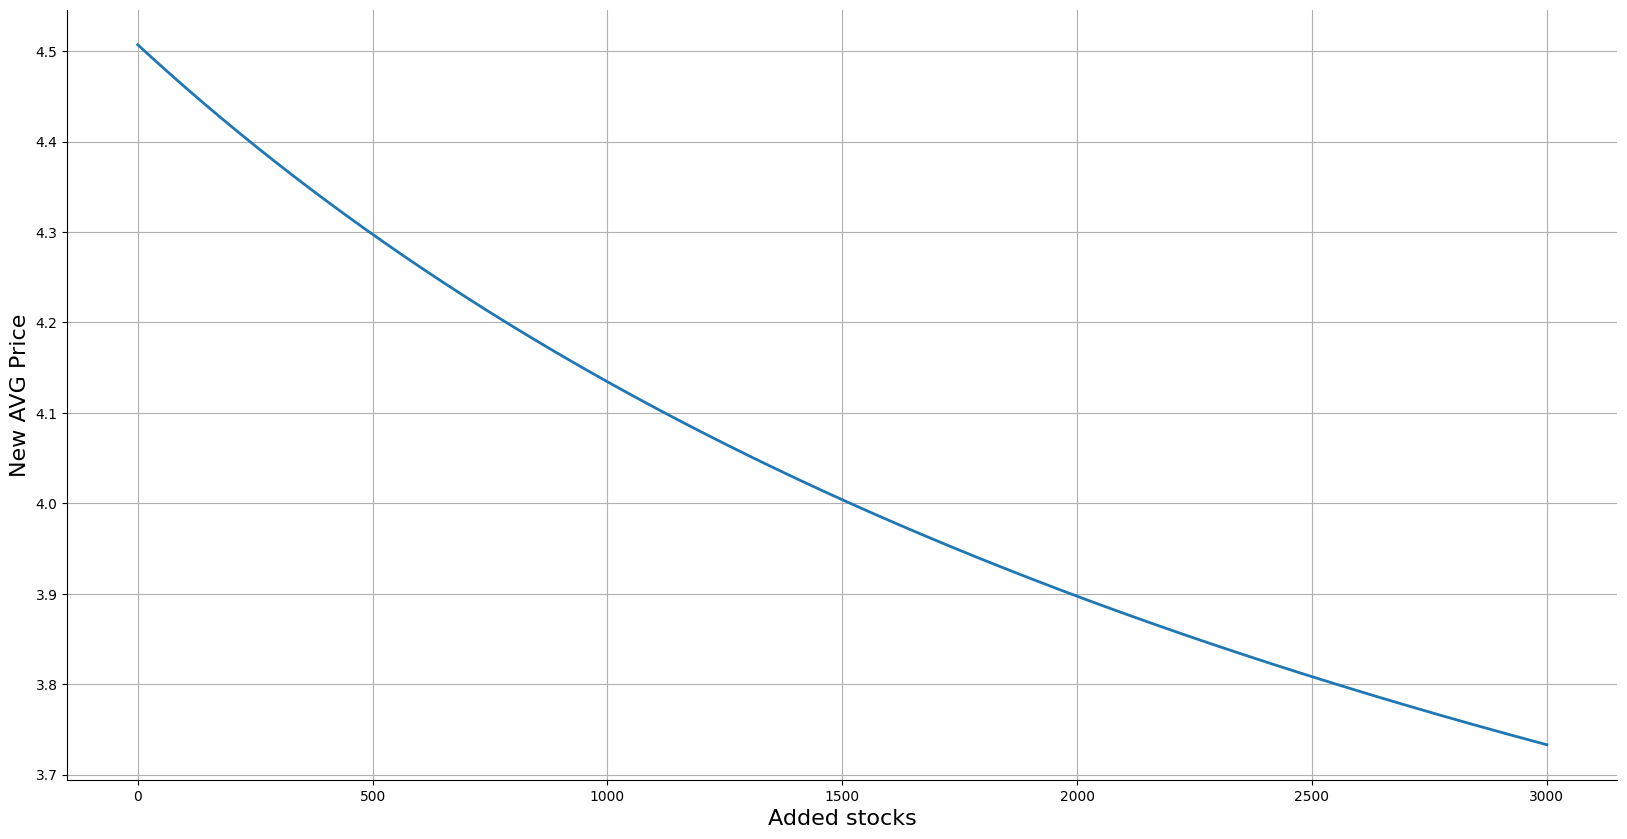

<Figure size 640x480 with 0 Axes>

In [3]:
N = 3000
x = [value for value in range(N+1)]
fx = [calculate_stock_avg (item) for item in x]

# figure object
fig = plt.figure(
                figsize=(20,10),
                )
# 1st axes
ax = fig.add_subplot(111)
# spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
# x axis
ax.set_xlabel('Added stocks', fontsize=16)
ax.xaxis.grid(True)
# ax.xaxis.set_tick_params(which='both', width=0, size=0, labelsize=0)
# y axis
ax.set_ylabel('New AVG Price', fontsize=16)
ax.yaxis.grid(True)
#ax.yaxis.set_tick_params(which='major', width=3, size=5, labelsize=16)
# line charts
ax.plot(x, fx, label='new AVG Stock Price', linewidth = '2')



# print chart
plt.show()
plt.clf()